### Imports

In [1]:
import os
import glob
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from lxml import etree, objectify
from html import unescape

### Config

In [2]:
data_dir = "data/dispecs-2019-06-17/"
results_dir = "results/"

In [3]:
plt.style.use("seaborn-whitegrid")
plt.rc('ps',fonttype = 42)
plt.rc('pdf',fonttype = 42)
plt.rcParams.update({'font.size': 20})
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False

### Process XML files

In [4]:
xml_filenames = glob.glob("{}*.xml".format(data_dir))

In [5]:
parser = etree.XMLParser(encoding="utf-8", recover=True, huge_tree=True)

In [6]:
namespaces = {"tei": "http://www.tei-c.org/ns/1.0"}

In [7]:
def_nde = {
    None: None,
    "E1": "Ebene 1",
    "E2": "Ebene 2",
    "E3": "Ebene 3",
    "E4": "Ebene 4",
    "E5": "Ebene 5",
    "E6": "Ebene 6"
}

def_ndf = {
    None: None,
    "AE": "Allgemeine Erzählung",
    "SP": "Selbstportrait",
    "FP": "Fremdportrait",
    "D": "Dialog",
    "AL": "Allegorisches Erzählen",
    "TR": "Traumerzählung",
    "F": "Fabelerzählung",
    "S": "Satirisches Erzählen",
    "EX": "Exemplarisches Erzählen",
    "UT": "Utopische Erzählung",
    "MT": "Metatextualität",
    "ZM": "Zitat/Motto",
    "LB": "Leserbrief"
}

In [23]:
# dict for errors
file_errors = {
    "title_element": [],
    "title_none": [],
    "volume_issues_element": [],
    "volume_none": [],
    "issue_none": [],
    "journal_title_element": [],
    "journal_title_none": [],
    "author_element": [],
    "author_none": [],
    "author_whitespace": [],
    "country_element": [],
    "country_none": [],
    "language_element": [],
    "language_none": [],
    "date_element": [],
    "date_none": [],
    "topics_none": [],
    "text_element": []
}

# temp results list
texts_list = []

# parse xml files
for fn in tqdm(xml_filenames):
    filename = fn.split("/")[-1]
    #print(filename)
    #if fn != "data/dispecs-2019-06-03/mws.3424.xml":continue
    
    et = etree.parse(fn, parser)
    
    # title
    try:
        title = et.xpath("//tei:titleStmt/tei:title", namespaces=namespaces)[0].text
        if title is None:
            title = "missing"
            file_errors["title_none"].append(filename)
    except IndexError:
        title = "missing"
        file_errors["title_element"].append(filename)
        
    # volume & issue
    try:
        volume, issue = et.xpath("//tei:sourceDesc/tei:bibl/tei:biblScope ", namespaces=namespaces)
        volume = volume.text
        issue = issue.text
        if volume is None:
            volume = "missing"
            file_errors["volume_none"].append(filename)
        if issue is None:
            issue = "missing"
            file_errors["issue_none"].append(filename)    
    except ValueError:
        volume = "missing"
        issue = "missing"
        file_errors["volume_issues_element"].append(filename)
        
    #journal title
    try:
        journal_title = et.xpath("//tei:sourceDesc/tei:bibl/tei:title ", namespaces=namespaces)[0].text.replace("\n", " ").strip()
        journal_title = re.sub(" +", " ", journal_title)
        if journal_title is None:
            file_errors["journal_title_none"].append(filename)
    except IndexError:
        journal_title = "missing"
        file_errors["journal_title_element"].append(filename)
    
    # author
    try:
        author = et.xpath("//tei:titleStmt/tei:author", namespaces=namespaces)[0].text        
        if author.endswith(" ") or author.startswith(" "):
            file_errors["author_whitespace"].append(filename)
            author = author.strip()
        author = re.sub("\s+", " ", author)
        if author == "Anónimo" or author == "Anonymus":
            author = "Anonym"
        if author is None:
            author = "missing"
            file_errors["author_none"].append(filename)
    except:
        author = "missing"
        file_errors["author_element"].append(filename)
    
    # country
    try:
        country = et.xpath("//tei:sourceDesc/tei:bibl/tei:placeName", namespaces=namespaces)[0].text
        if country is None:
            country = "missing"
            file_errors["country_none"].append(filename)
    except IndexError:
        country = "missing"
        file_errors["country_element"].append(filename)
    
    # language
    try:
        language = et.xpath("//tei:profileDesc/tei:langUsage/tei:language", namespaces=namespaces)[0].text
        if language is None:
            language = "missing"
            file_errors["language_none"].append(filename)
    except IndexError:
        language = "missing"
        file_errors["language_element"].append(filename)
    
    # date
    try:
        date = et.xpath("//tei:sourceDesc/tei:bibl/tei:date", namespaces=namespaces)[0].text
        if date is None:
            date = "missing"
            file_errors["date_none"].append(filename)
    except IndexError:
        date = "missing"
        file_errors["date_element"].append(filename)
    
    # topics
    topics = set()
    for t in et.xpath("//tei:profileDesc/tei:textClass/tei:keywords/tei:term/tei:term[@xml:lang='en']", namespaces=namespaces):
        topics.add(re.sub("\s+", " ", t.text).strip())
    if len(topics) == 0:
        file_errors["topics_none"].append(filename)
    
    basic_results = {
        "filename": filename,
        "title": title,
        "volume": volume,
        "issue": issue,
        "author": author,
        "country": country,
        "language": language,
        "date": date,
        "topics": topics,
    }
    
    # text
    index = pd.MultiIndex.from_product([def_nde.keys(), def_ndf.keys()],  names=["nde", "ndf"])
    temp_text_df = pd.DataFrame(index=index, columns=["text", "places", "persons"])
    temp_text_df["text"] = ""
    temp_text_df["places"] = [set() for i in range(len(temp_text_df))]
    temp_text_df["persons"] = [set() for i in range(len(temp_text_df))]
    temp_text_df["works"] = [set() for i in range(len(temp_text_df))]
    temp_text_df["filename"] = filename
    temp_text_df["title"] = re.sub("\s+", " ", title).strip()
    temp_text_df["volume"] = re.sub("\s+", " ", volume).strip()
    temp_text_df["issue"] = re.sub("\s+", " ", issue).strip()
    temp_text_df["journal_title"] = re.sub("\s+", " ", journal_title).strip()
    temp_text_df["author"] = re.sub("\s+", " ", author).strip()
    temp_text_df["country"] = re.sub("\s+", " ", country).strip()
    temp_text_df["language"] = re.sub("\s+", " ", language).strip()
    temp_text_df["date"] = re.sub("\s+", " ", date).strip()
    temp_text_df["topics"] = [topics for i in range(len(temp_text_df))]
            
    try:
        text_element = et.xpath("//tei:text[@ana='layout']/tei:body", namespaces=namespaces)[0]
    except IndexError:
        file_errors["text_element"].append(filename)
        continue
    
    cur_ndes = [None]
    cur_ndfs = [None]
    for c in text_element.iterdescendants():
        tag = c.tag.replace("{http://www.tei-c.org/ns/1.0}", "")
        #print(tag)
        if tag == "milestone":
            kind = c.attrib["unit"]
            if kind in def_nde:
                try:
                    c.attrib["rend"]
                    if len(cur_ndes) > 1: cur_ndes.pop()
                except KeyError:
                    cur_ndes.append(kind)
            elif kind in def_ndf:
                try:
                    c.attrib["rend"]
                    if len(cur_ndfs) > 1: cur_ndfs.pop()
                except KeyError:
                    cur_ndfs.append(kind)
            #print(cur_ndes, cur_ndf)
            try:
                temp_text_df.loc[(cur_ndes[-1], cur_ndfs[-1]), "text"] += " " + c.tail
            except (TypeError, KeyError):
                pass
        if tag == "head":
            try:
                temp_text_df.loc[(cur_ndes[-1], cur_ndfs[-1]), "text"] += " " + c.text
            except TypeError:
                pass
        if tag == "p":
            try:
                temp_text_df.loc[(cur_ndes[-1], cur_ndfs[-1]), "text"] += " " + c.text
            except TypeError:
                pass
        if tag == "placeName":
            try:
                temp_text_df.loc[(cur_ndes[-1], cur_ndfs[-1]), "places"].add(c.text)
                temp_text_df.loc[(cur_ndes[-1], cur_ndfs[-1]), "text"] += " " + c.text
                temp_text_df.loc[(cur_ndes[-1], cur_ndfs[-1]), "text"] += " " + c.tail
            except TypeError:
                pass
        if tag == "persName":
            try:
                temp_text_df.loc[(cur_ndes[-1], cur_ndfs[-1]), "persons"].add(c.text)
                temp_text_df.loc[(cur_ndes[-1], cur_ndfs[-1]), "text"] += " " + c.text
                temp_text_df.loc[(cur_ndes[-1], cur_ndfs[-1]), "text"] += " " + c.tail
            except TypeError:
                pass
        if tag == "name":
            try:
                temp_text_df.loc[(cur_ndes[-1], cur_ndfs[-1]), "works"].add(c.text)
                temp_text_df.loc[(cur_ndes[-1], cur_ndfs[-1]), "text"] += " " + c.text
                temp_text_df.loc[(cur_ndes[-1], cur_ndfs[-1]), "text"] += " " + c.tail
            except TypeError:
                pass
        if tag == "hi":
            try:
                temp_text_df.loc[(cur_ndes[-1], cur_ndfs[-1]), "text"] += " " + c.text
                temp_text_df.loc[(cur_ndes[-1], cur_ndfs[-1]), "text"] += " " + c.tail                 
            except (TypeError, IndexError):
                pass
        if tag == "lb" or tag == "pb":
            try:
                temp_text_df.loc[(cur_ndes[-1], cur_ndfs[-1]), "text"] += " " +  c.text
                temp_text_df.loc[(cur_ndes[-1], cur_ndfs[-1]), "text"] += " " +  c.tail
            except:
                pass
    
    # prepare data
    temp_text_df = temp_text_df[temp_text_df["text"].apply(lambda x: len(x.strip()) > 0)].reset_index()
    temp_text_df["text"] = temp_text_df["text"].apply(lambda x: re.sub("\s+", " ", x).strip())
    texts_list.append(temp_text_df)
    
texts_df = pd.concat(texts_list, ignore_index=True, sort=False)

In [24]:
texts_df.loc[7645, "title"]

'Discours Premier'

### Save processed texts

In [25]:
texts_df.to_pickle("data/processed/texts.p")

### Plot file errors

In [26]:
error_results = pd.Series({key:len(value) for (key, value) in file_errors.items()})

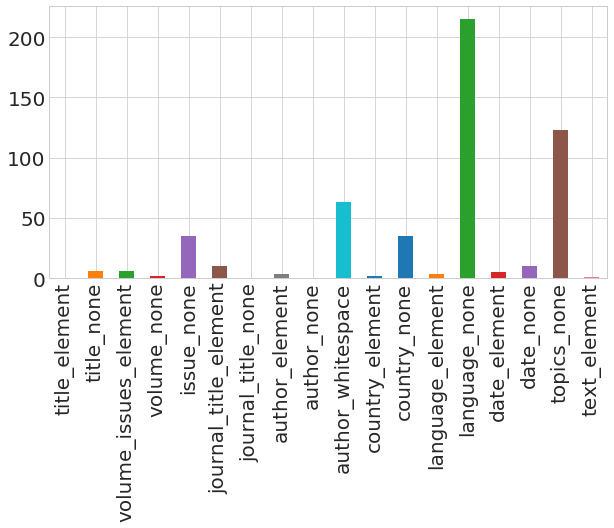

In [27]:
error_results.plot(kind="bar", figsize=[10,5])

### Save errors to csv

In [28]:
pd.Series(file_errors).apply(lambda x:", ".join(x)).to_csv("{}file_errors.csv".format(results_dir), sep=";")